# Report 03
#### Matthew Beaudouin-Lafon

In [11]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalNormalCdf, EvalNormalPdf, EvalBinomialPmf, EvalExponentialPdf
import thinkplot

from itertools import product

## The Unreliable Amazon Seller Problem
#### By Matthew Beaudouin-Lafon

I bought an item on Amazon because it advertised an impressive lifetime of two years. However, I take a look at the reviews, notice three reviews which state that their item broke after 1.1 year, 2.6 years (a dedicated amazon reviewer!) and 0.7 years. When should I expect my item to break?

##### Solution
We can model the failure rate with the [Weibull Distribution](https://en.wikipedia.org/wiki/Weibull_distribution). 
Since we don't have a lot of data, we need to make an assumption in relation to the shape of the curve (defined by the parameter k). Without 

In [12]:
class Amazon(Suite):
    
    def Likelihood(self, data, hypo):
        """
        Parameters:
            - data: lifetime of the item (in years)
        """
        return EvalExponentialPdf(data, hypo)

In [43]:
amazon = Amazon(np.linspace(0, 10, 100)) # We assume that the average is between 0 and 5 years (with 100 samples)

In [44]:
amazon.Update(2) # Update only based off of the seller's information
amazon.Mean()

1.0033983253396261

In [45]:
# amazon.UpdateSet([1.1, 2.6, 0.7]) # Update based off of all reviews.
amazon.Update(1)
amazon.Mean()

1.0000463383299767

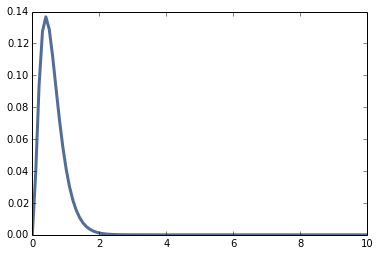

In [42]:
thinkplot.Pdf(amazon)

## Allergic Diner Problem
#### From Think Bayes Chapter 5
Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats. Because you have cats, you expect 50% of the allergic guests to sneeze during dinner. At the same time, you expect 10% of the non-allergic guests to sneeze. What is the distribution of the total number of guests who sneeze?

In [214]:
2 * [4]

[4, 4]

## GPS Problem 
#### From Think Bayes Chapter 9

> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

In [38]:
class GPS(Suite, Joint):
    """
    Bayesian model for the GPS Problem. Inherits from Suite and Joint.
    """
    
    def Likelihood(self, data, hypo):
        """
        Parameters:
            - data: (x, y) tuple representing gps data
            - hypo: (x, y) tuple representing hypothetical position
        
        Probability of the data under the hypothesis.
        """
        x, y = hypo
        gpsX, gpsY = data
        
        likeX = EvalNormalPdf(gpsX - x, 0, 30)
        likeY = EvalNormalPdf(gpsY - y, 0, 30)
        return likeX*likeY                       # The likelihoods are multiplied because x and y are independent variables

xPos = range(0, 200)
yPos = range(0, 200)
gps = GPS(product(xPos, yPos))

In [39]:
gps.Update((51, 15))

1.6683006153592209e-05

In [40]:
gps.Update((48, 90))

2.727787826619526e-05

In [41]:
gps.UpdateSet([(11.903060613102866, 19.79168669735705), 
(77.10743601503178, 39.87062906535289), 
(80.16596823095534, -12.797927542984425), 
(67.38157493119053, 83.52841028148538),
(89.43965206875271, 20.52141889230797),
(58.794021026248245, 30.23054016065644),
(2.5844401241265302, 51.012041625783766),
(45.58108994142448, 3.5718287379754585)])

7.3944260587465136e-35

90% credible interval for x:  (38, 69)
90% credible interval for y:  (18, 50)

In other words, there's a 90% chance that we are at (53.5 +- 15.5, 34.0 +- 16.0)
Since we are in a 200m square, the errors for x and y are 7.75% and 8.0% respectively.


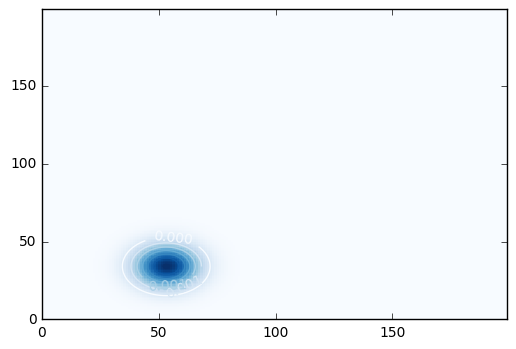

In [63]:
thinkplot.Contour(gps, pcolor=True)
credX = gps.Marginal(0).CredibleInterval()
credY = gps.Marginal(1).CredibleInterval()
print('90% credible interval for x: ', credX)
print('90% credible interval for y: ', credY)
likelyX = sum(credX) / 2.0
likelyY = sum(credY) / 2.0
errorX = credX[1] - likelyX
errorY = credY[1] - likelyY
print()
print('In other words, there\'s a 90% chance that we are at ({} +- {}, {} +- {})'
      .format(likelyX, errorX, likelyY, errorY))
print('Since we are in a 200m square, the errors for x and y are {}% and {}% respectively.'.format(errorX/2.0,errorY/2.0))

## Lincoln Index Problem 
#### From John D. Cook
"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

"Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find. The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs. What is the Bayesian estimate of the number of errors based on this data?

In [253]:
# Forward problem: Given the probabilities and the number of bugs, 
p1 = 0.4 # Probability tester finds any given bug
p2 = 0.6
n = 100.0  # Number of bugs

K1 = []
K2 = []
C = []

for i in range(1000):
    sample1 = np.random.random(size=n) < p1 # Number of bugs the tester finds
    sample2 = np.random.random(size=n) < p2
    k1 = np.sum(sample1) / n                # Bug finding rate
    k2 = np.sum(sample2) / n
    c = np.sum(sample1 & sample2) / n       # Bugs both testers found
    K1.append(k1)
    K2.append(k2)
    C.append(c)

t1 = sum(K1)/len(K1)
t2 = sum(K2)/len(K2)
c = sum(C)/len(C)
print('Tester 1 success rate: {}, tester 2 success rate {}, rate of redundant bugs found: {}'
      .format(t1, t2, c))
print('\n For any bug, we can consider a probability tree:')
print('''
    __  
   /  \  
  F    N      Tester 1  
 /\    /\  
F  N  F  N    Tester 2  
^
Both testers find the bug. Since they respectively have p1 and p2 probability of finding any bug, 
the probability they both find the bug is p1*p2.''')
print('We can test this with the experimental data above: p1 * p2 = {} * {} = {}, which is within {}% of the experiment.'
      .format(t1, t2, t1 * t2, 100*(t1*t2 - c) / c))

Tester 1 success rate: 0.399185, tester 2 success rate 0.600357, rate of redundant bugs found: 0.239646

 For any bug, we can consider a probability tree:

    __  
   /  \  
  F    N      Tester 1  
 /\    /\  
F  N  F  N    Tester 2  
^
Both testers find the bug. Since they respectively have p1 and p2 probability of finding any bug, 
the probability they both find the bug is p1*p2.
We can test this with the experimental data above: p1 * p2 = 0.399185 * 0.600357 = 0.239653509045, which is within 0.00313339049972% of the experiment.


In [257]:
class Lincoln(Suite, Joint):
    """
    
    """
    def Likelihood(self, data, hypo):
        """
        data: k1, k2, c
        hypo: n, p1, p2
        """
        k1, k2, c = data
        n, p1, p2 = hypo
        like1 = EvalBinomialPmf(k1, p1, n)
        like2 = EvalBinomialPmf(k2, p2, n)
        likeC = EvalBinomialPmf(c, p1, n) * EvalBinomialPmf(c, p2, n)
        return like1 * like2 * likeC
    
numSamples = 10.0
P1 = [i/numSamples in range(int(numSamples))]
P2 = [i/numSamples in range(int(numSamples))]
N = np.linspace(20, 100, 10)
print(P1)

lincoln = Lincoln(product(P1, P2, N))

[False]


In [256]:
lincoln.Update((20, 15, 3))

ValueError: Normalize: total probability is zero.

In [92]:
thinkplot.Contour(lincoln)

ValueError: too many values to unpack

## Flea Beettle Problem
#### From [DASL](http://lib.stat.cmu.edu/DASL/Datafiles/FleaBeetles.html)
Datafile Name: Flea Beetles

Datafile Subjects: Biology

Story Names: Flea Beetles

Reference: Lubischew, A.A. (1962) On the use of discriminant functions in taxonomy. Biometrics, 18, 455-477. Also found in: Hand, D.J., et al. (1994) A Handbook of Small Data Sets, London: Chapman & Hall, 254-255.

Authorization: Contact Authors

Description: Data were collected on the genus of flea beetle Chaetocnema, which contains three species: concinna (Con), heikertingeri (Hei), and heptapotamica (Hep). Measurements were made on the width and angle of the aedeagus of each beetle. The goal of the original study was to form a classification rule to distinguish the three species.

Number of cases: 74

Variable Names:

Width: The maximal width of aedeagus in the forpart (in microns)

Angle: The front angle of the aedeagus (1 unit = 7.5 degrees)

Species: Species of flea beetle from the genus Chaetocnema

## The Manufacturer Failure Rate Problem
#### By Matthew Beaudouin-Lafon
You've created a product and are trying to determine its failure rate. With the following data,  

In [254]:
np.linspace(20,200,10)


array([  20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.,  200.])